Testing script which looks at spin assembly bias.

In [2]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import kin_morph_funcs as knf
from astropy.cosmology import Planck15
from scipy import interpolate
import scipy.stats as stats
import scipy

In [3]:
from matplotlib import rcParams
from matplotlib import rc

# rc('text', usetex=True)
rcParams['axes.linewidth'] = 2.5
rcParams['xtick.major.size'] = 5
rcParams['ytick.major.size'] = 5
rcParams['xtick.minor.size'] = 3.5
rcParams['ytick.minor.size'] = 3.5

rcParams['xtick.major.width'] = 2
rcParams['ytick.major.width'] = 2
rcParams['xtick.minor.width'] = 1.5
rcParams['ytick.minor.width'] = 1.5

rcParams['xtick.top'] = True
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'

rcParams['xtick.labelsize'] = 'x-large'
rcParams['ytick.labelsize'] = 'x-large'

rcParams['xtick.major.pad'] = 5
rcParams['ytick.major.pad'] = 5
rcParams['lines.linewidth'] = 2.5

In [4]:
def create_matched_mass_sample_unique(masses, tab, col_name='stel_mass_x'):
    '''
    Given a set of masses, this returns a control sample with a similar mass distribution. 
    Each match in the control sample will be a unique galaxy.
    Make sure that the you have removed the comparison sample from your table.
    '''
    iter_tab = tab
    indices = np.array([])
    for mass in masses:
        idx = iter_tab.index[(np.abs(iter_tab[col_name].values - mass)).argmin()]
        indices = np.append(indices, idx)
        iter_tab = iter_tab.drop(idx)
    return tab.loc[indices]

# using only disky objects and separating on distance to filamentary structure.
# comparing to filament agnostic control sample.

def return_tabs(intab, min_mass=0, max_mass=10**12, mass_col='halo_mass_stel'):
    mask = (intab.log_dskel_norm.values < np.log10(1.5)) & (intab.log_dnode_norm.values > np.log10(2)) & (intab[mass_col].values > min_mass) & (intab[mass_col].values < max_mass)   
    filament_tab = intab[mask]
    residual_tab = intab.drop(filament_tab.index)
    control_tab = create_matched_mass_sample_unique(filament_tab[mass_col].values, residual_tab, col_name=mass_col)  
    
    # node sample.
    node_mask = (intab.log_dnode_norm.values < np.log10(1)) & (intab[mass_col].values > min_mass) & (intab[mass_col].values < max_mass)
    node_tab = intab[node_mask]

    # no cw
    ncw_mask = (intab.log_dnode_norm.values > np.log10(1)) & (intab.log_dskel_norm.values > np.log10(1)) & (intab[mass_col].values > min_mass) & (intab[mass_col].values < max_mass)
    ncw_tab = intab[ncw_mask]
    return filament_tab, control_tab, node_tab, ncw_tab, residual_tab


In [6]:
# loading in cosmic web catalogues and matching manga ids to get info for all MaNGA targets.
inpath = '/Users/chrisduckworth/astronomy/projects/spin_bias/catalogues/'
mid = pd.read_csv(inpath+'MaNGA_IDs')
cw = pd.read_csv(inpath+'CW_mpl6_yang_s5.csv')#'CW_SDSS_GC1_S3/DR10_MaNGA_matched_S3.csv')

# merging catalogues and finding manga targets only.
cw_manga_targets = mid.merge(cw, left_on='ID', right_on='ID')

# match to morphology information.
gz = pd.read_csv(inpath+'MaNGA_gz-v1_0_1.csv')
cw_manga_targets_gz = cw_manga_targets.merge(gz, on='MANGAID')

# matching this to my own catalogue because pipe3d don't know what a mangaid is.
mpl8 = pd.read_csv(inpath+'mpl8_main_TNG_ref.csv')
cw_gz_mpl8 = mpl8.merge(cw_manga_targets_gz, left_on='mangaid', right_on='MANGAID')

# matching to angular momentum info.
pipe3d = pd.read_csv(inpath+'manga.Pipe3D_v2_5_3.csv')
cw_gz_pipe3d_mpl8 = cw_gz_mpl8.merge(pipe3d, left_on='plateifu', right_on='plateifu')

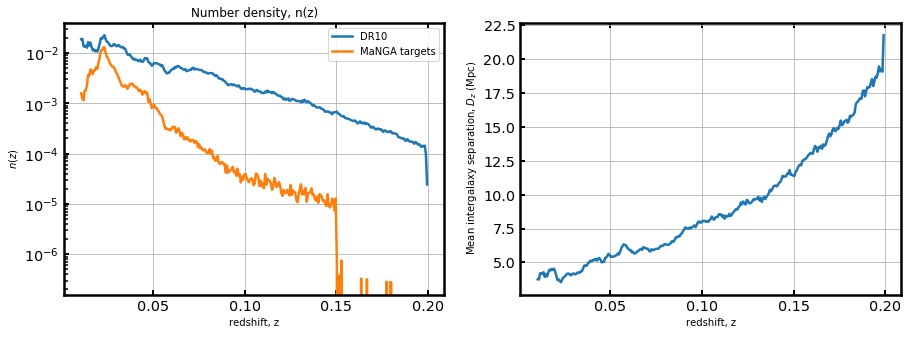

In [7]:
# constructing normalisation for galaxy sampling.

# SDSS DR10 (7966 sq deg) with the redshift limit of z=0.2.
DR10 = fits.open(inpath+'CW_mpl6_yang_s5')[1].data
z_dr10 = DR10['zobs'][(DR10['zobs'] <= 0.2) & (DR10['zobs'] >= 0)]

# Finding redshift range of MaNGA targets only! 
mngtarg_min = min(DR10['zobs'][DR10['ID'] != - 9999])
mngtarg_max = max(DR10['zobs'][DR10['ID'] != - 9999])
# Number of galaxies per redshift bin.
fig,ax = plt.subplots(1,2,figsize=(15,5))
plt.sca(ax[0])
N_z = np.histogram(z_dr10,bins=np.linspace(mngtarg_min,0.2,301))
N_z_manga = np.histogram(DR10['zobs'][DR10['ID'] != - 9999],bins=N_z[1])

#ax[1].plot([np.mean(D_z[:-1]).value,np.mean(D_z[:-1]).value],[0,3500],'k-.')

# Finding the fraction of the sky covered by DR10.
whole_sky_area = 4*np.pi*(180/np.pi)**2 # steradians converted to sq degs.
frac = 7966 / whole_sky_area
# So e.g. volume up to redshift of 0.1
total_vols = frac*Planck15.comoving_volume(N_z[1])
slice_vols = total_vols[1:] - total_vols[:-1]

# So for each redshift slice n = N/V:
number_density = N_z[0] / slice_vols
number_density_manga = N_z_manga[0] / slice_vols

# Now finding the euclidean inter galaxy separation as a function of redshift.
D_z = number_density**(-1/3)

# Finding bin centres
bin_cen = (N_z[1][:-1] + N_z[1][1:])/2
D_z_interpolate = interpolate.interp1d(bin_cen[:-1],D_z[:-1], kind='cubic')
xnew = np.linspace(mngtarg_min,mngtarg_max, num=301, endpoint=True)

ax[0].set_title('Number density, n(z)')
ax[0].plot(bin_cen,number_density.value,label='DR10')
ax[0].plot(bin_cen,number_density_manga.value,label='MaNGA targets')
ax[0].set_yscale('log')
ax[0].legend()
ax[0].set_xlabel('redshift, z')
ax[0].set_ylabel(r'$n(z)$')
ax[0].grid()

ax[1].plot(bin_cen[:-1],D_z[:-1],label='Euclidean')
ax[1].set_ylabel(r' Mean intergalaxy separation, $D_z$ (Mpc)')
ax[1].set_xlabel(r'redshift, z')
ax[1].grid()

def get_axis_limits(ax, scale=.9):
    return ax.get_xlim()[1]*scale*0.75, 0.1#ax.get_ylim()[1]*scale

ax[1].annotate('Median = '+str(round(np.median(D_z[:-1]).value,3))+' Mpc\nMean    = '+str(round(np.mean(D_z[:-1]).value,3))+' Mpc', xy=get_axis_limits(ax[1]))
plt.show()

In [8]:
# computing normalised distances and adding as additional column.

cw_gz_pipe3d_mpl8['log_dskel_norm'] = cw_gz_pipe3d_mpl8.log_dskel.values - np.log10(D_z_interpolate(cw_gz_pipe3d_mpl8.z.values))
cw_gz_pipe3d_mpl8['log_dwall_norm'] = cw_gz_pipe3d_mpl8.log_dwall.values - np.log10(D_z_interpolate(cw_gz_pipe3d_mpl8.z.values))
cw_gz_pipe3d_mpl8['log_dnode_norm'] = cw_gz_pipe3d_mpl8.log_dnode.values - np.log10(D_z_interpolate(cw_gz_pipe3d_mpl8.z.values))


In [9]:
# selecting only mpl8 galaxies.
cw_gz_pipe3d_mpl8_kinpa = cw_gz_pipe3d_mpl8[(cw_gz_pipe3d_mpl8.stel_feature == 0) & (cw_gz_pipe3d_mpl8.halpha_feature == 0) & ((cw_gz_pipe3d_mpl8.stel_qual == 1) | (cw_gz_pipe3d_mpl8.stel_qual == 2)) & ((cw_gz_pipe3d_mpl8.halpha_qual == 1) | (cw_gz_pipe3d_mpl8.halpha_qual == 2))]
# selecting only centrals.
cw_gz_pipe3d_mpl8_cens = cw_gz_pipe3d_mpl8[(cw_gz_pipe3d_mpl8.massive_flag.values == 1) & (cw_gz_pipe3d_mpl8.f_edge.values > 0.6) & (cw_gz_pipe3d_mpl8.halo_mass_stel.values > 0)]


In [10]:
# splitting on morphology.
etgs, S0_Sas, Sb_Sds = knf.morph_breakdown(cw_gz_pipe3d_mpl8_cens)
all_spirals = pd.concat([S0_Sas, Sb_Sds])
all_early = pd.concat([S0_Sas, etgs])

Ks_2sampResult(statistic=0.16964285714285715, pvalue=0.07956322135234484)


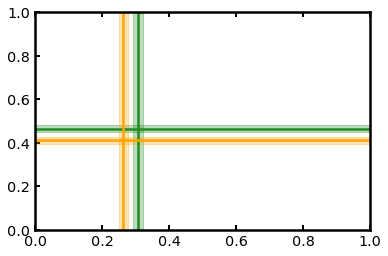

In [11]:
#%matplotlib notebook

filament_tab, control_tab, node_tab, ncw_tab, _ = return_tabs(S0_Sas[(S0_Sas.halo_mass_stel.values > 12) & (S0_Sas.halo_mass_stel.values < 13)], min_mass=0, max_mass=1, mass_col='dtfe_gauss_3Mpc')
# plotting lambda_Re plot.
fig, ax = plt.subplots()
ax.axhline(np.median(filament_tab.lambda_re.values), color='forestgreen')
ax.axhspan(np.median(filament_tab.lambda_re.values) - stats.sem(filament_tab.lambda_re.values),
           np.median(filament_tab.lambda_re.values) + stats.sem(filament_tab.lambda_re.values), 
           linestyle='solid', color='forestgreen', alpha=0.3, zorder=2)
ax.axvline(np.median(1 - filament_tab.nsa_elpetro_ba.values), color='forestgreen')
ax.axvspan(np.median(1 - filament_tab.nsa_elpetro_ba.values) - stats.sem(1 - filament_tab.nsa_elpetro_ba.values),
           np.median(1 - filament_tab.nsa_elpetro_ba.values) + stats.sem(filament_tab.lambda_re.values), 
           linestyle='solid', color='forestgreen', alpha=0.3, zorder=2)
#im = ax.scatter(1 - filament_Sb_Sds.nsa_elpetro_ba.values, filament_Sb_Sds.lambda_re.values, color='forestgreen')

ax.axhline(np.median(control_tab.lambda_re.values), color='orange')
ax.axvline(np.median(1 - control_tab.nsa_elpetro_ba.values),  color='orange')
ax.axhspan(np.median(control_tab.lambda_re.values) - stats.sem(control_tab.lambda_re.values),
           np.median(control_tab.lambda_re.values) + stats.sem(control_tab.lambda_re.values), 
           linestyle='solid', color='orange', alpha=0.3, zorder=2)
ax.axvspan(np.median(1 - control_tab.nsa_elpetro_ba.values) - stats.sem(1 - control_tab.nsa_elpetro_ba.values),
           np.median(1 - control_tab.nsa_elpetro_ba.values) + stats.sem(control_tab.lambda_re.values), 
           linestyle='solid', color='orange', alpha=0.3, zorder=2)

#im2 = ax.scatter(1 - control_Sb_Sds.nsa_elpetro_ba.values, control_Sb_Sds.lambda_re.values, color='orange')

# ax.axhline(np.median(node_tab.lambda_re.values), color='steelblue')
# ax.axvline(np.median(1 - node_tab.nsa_elpetro_ba.values),  color='steelblue')
# ax.axhspan(np.median(node_tab.lambda_re.values) - stats.sem(node_tab.lambda_re.values),
#            np.median(node_tab.lambda_re.values) + stats.sem(node_tab.lambda_re.values), 
#            linestyle='solid', color='steelblue', alpha=0.3, zorder=2)
# ax.axvspan(np.median(1 - node_tab.nsa_elpetro_ba.values) - stats.sem(1 - node_tab.nsa_elpetro_ba.values),
#            np.median(1 - node_tab.nsa_elpetro_ba.values) + stats.sem(node_tab.lambda_re.values), 
#            linestyle='solid', color='steelblue', alpha=0.3, zorder=2)
#im3 = ax.scatter(1 - node_Sb_Sds.nsa_elpetro_ba.values, node_Sb_Sds.lambda_re.values, color='steelblue')

# ax.axhline(np.median(ncw_tab.lambda_re.values), color='purple')
# ax.axvline(np.median(1 - ncw_tab.nsa_elpetro_ba.values),  color='purple')
#im3 = ax.scatter(1 - node_Sb_Sds.nsa_elpetro_ba.values, node_Sb_Sds.lambda_re.values, color='purple')

# checking significance of higher spin.
print(stats.ks_2samp(filament_tab.lambda_re.values, control_tab.lambda_re.values))

ax.set_xlim([0,1])
ax.set_ylim([0,1])
plt.show()

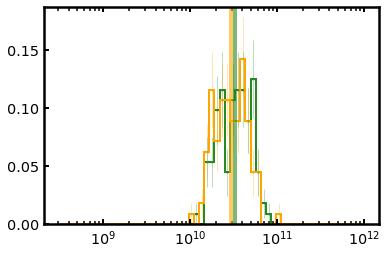

Text(0.58, 0.91, '$\\mathrm{KS}=$0.134 $p=$0.268')

In [12]:
bins = np.logspace(8.5, 12, 60)
fig, ax = plt.subplots()
knf.histerr(filament_tab.nsa_elpetro_mass.values, ax, bins=bins, color='forestgreen', median=True)
knf.histerr(control_tab.nsa_elpetro_mass.values, ax, bins=bins, color='orange', median=True)
ax.set_xscale('log')
plt.show()

ks, p = stats.ks_2samp(filament_tab.nsa_elpetro_mass.values, control_tab.nsa_elpetro_mass.values)
ax.annotate(r'$\mathrm{KS}=$'+str(round(ks, 3))+r' $p=$'+str(np.round(p, 3)), 
               xy=(0.58, 0.91), xycoords='axes fraction', fontsize=13.5 )

No handles with labels found to put in legend.


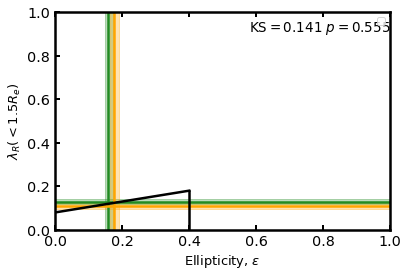

(64, 417)


In [13]:
filament_tab, control_tab, node_tab, ncw_tab,_ = return_tabs(etgs[(etgs.halo_mass_stel.values > np.percentile(etgs.halo_mass_stel.values, 66)) & (etgs.halo_mass_stel.values < np.percentile(etgs.halo_mass_stel.values, 100))], min_mass=0, max_mass=1, mass_col='dtfe_gauss_3Mpc')

# plotting lambda_Re plot.
fig, ax = plt.subplots()
ax.axhline(np.median(filament_tab.lambda_re.values), color='forestgreen', label='')
ax.axhspan(np.median(filament_tab.lambda_re.values) - stats.sem(filament_tab.lambda_re.values),
           np.median(filament_tab.lambda_re.values) + stats.sem(filament_tab.lambda_re.values), 
           linestyle='solid', color='forestgreen', alpha=0.3, zorder=2)
ax.axvline(np.median(1 - filament_tab.nsa_elpetro_ba.values), color='forestgreen')
ax.axvspan(np.median(1 - filament_tab.nsa_elpetro_ba.values) - stats.sem(1 - filament_tab.nsa_elpetro_ba.values),
           np.median(1 - filament_tab.nsa_elpetro_ba.values) + stats.sem(filament_tab.lambda_re.values), 
           linestyle='solid', color='forestgreen', alpha=0.3, zorder=2)
#im = ax.scatter(1 - filament_Sb_Sds.nsa_elpetro_ba.values, filament_Sb_Sds.lambda_re.values, color='forestgreen')

ax.axhline(np.median(control_tab.lambda_re.values), color='orange')
ax.axvline(np.median(1 - control_tab.nsa_elpetro_ba.values),  color='orange')
ax.axhspan(np.median(control_tab.lambda_re.values) - stats.sem(control_tab.lambda_re.values),
           np.median(control_tab.lambda_re.values) + stats.sem(control_tab.lambda_re.values), 
           linestyle='solid', color='orange', alpha=0.3, zorder=2)
ax.axvspan(np.median(1 - control_tab.nsa_elpetro_ba.values) - stats.sem(1 - control_tab.nsa_elpetro_ba.values),
           np.median(1 - control_tab.nsa_elpetro_ba.values) + stats.sem(control_tab.lambda_re.values), 
           linestyle='solid', color='orange', alpha=0.3, zorder=2)

# ax.axhline(np.median(node_tab.lambda_re.values), color='steelblue')
# ax.axvline(np.median(1 - node_tab.nsa_elpetro_ba.values),  color='steelblue')
# ax.axhspan(np.median(node_tab.lambda_re.values) - stats.sem(node_tab.lambda_re.values),
#            np.median(node_tab.lambda_re.values) + stats.sem(node_tab.lambda_re.values), 
#            linestyle='solid', color='steelblue', alpha=0.3, zorder=2)
# ax.axvspan(np.median(1 - node_tab.nsa_elpetro_ba.values) - stats.sem(1 - node_tab.nsa_elpetro_ba.values),
#            np.median(1 - node_tab.nsa_elpetro_ba.values) + stats.sem(node_tab.lambda_re.values), 
#            linestyle='solid', color='steelblue', alpha=0.3, zorder=2)

ks, p = stats.ks_2samp(filament_tab.lambda_re.values, control_tab.lambda_re.values)
ax.annotate(r'$\mathrm{KS}=$'+str(round(ks, 3))+r' $p=$'+str(np.round(p, 3)), 
               xy=(0.58, 0.91), xycoords='axes fraction', fontsize=13.5 )

# adding on classically defined SR region 
elp_cond = np.linspace(0,0.4,10)
lam_cond = 0.08 + elp_cond/4
ax.plot(elp_cond,lam_cond,'k')
ax.plot([0.4,0.4],[0,0.18],'k')

ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel('Ellipticity, $\epsilon$', fontsize=13)
ax.set_ylabel(r'$\lambda_{R}(< 1.5R_{e})$', fontsize=13)
ax.legend()
ax.set_xlim([0,1])
ax.set_ylim([0,1])
plt.show()

print(filament_tab.shape)

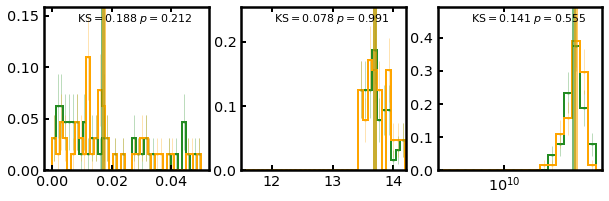

In [14]:
bins = np.linspace(0, 0.05, 40)
fig, ax = plt.subplots(1,3, figsize=(10,3))
knf.histerr(filament_tab.dtfe_gauss_3Mpc.values, ax[0], bins=bins, color='forestgreen', median=True)
knf.histerr(control_tab.dtfe_gauss_3Mpc.values, ax[0], bins=bins, color='orange', median=True)
ks, p = stats.ks_2samp(filament_tab.dtfe_gauss_3Mpc.values, control_tab.dtfe_gauss_3Mpc.values)
ax[0].annotate(r'$\mathrm{KS}=$'+str(round(ks, 3))+r' $p=$'+str(np.round(p, 3)), 
               xy=(0.2, 0.91), xycoords='axes fraction', fontsize=11)

bins = np.linspace(11.5, 14.5, 40)
knf.histerr(filament_tab.halo_mass_stel.values, ax[1], bins=bins, color='forestgreen', median=True)
knf.histerr(control_tab.halo_mass_stel.values, ax[1], bins=bins, color='orange', median=True)

ks, p = stats.ks_2samp(filament_tab.halo_mass_stel.values, control_tab.halo_mass_stel.values)
ax[1].annotate(r'$\mathrm{KS}=$'+str(round(ks, 3))+r' $p=$'+str(np.round(p, 3)), 
               xy=(0.2, 0.91), xycoords='axes fraction', fontsize=11 )
ax[1].set_xlim([11.5,14.2])

bins = np.logspace(8.5, 12, 30)
knf.histerr(filament_tab.nsa_elpetro_mass.values, ax[2], bins=bins, color='forestgreen', median=True)
knf.histerr(control_tab.nsa_elpetro_mass.values, ax[2], bins=bins, color='orange', median=True)

ks, p = stats.ks_2samp(filament_tab.nsa_elpetro_mass.values, control_tab.nsa_elpetro_mass.values)
ax[2].annotate(r'$\mathrm{KS}=$'+str(round(ks, 3))+r' $p=$'+str(np.round(p, 3)),
               xy=(0.2, 0.91), xycoords='axes fraction', fontsize=11)
ax[2].set_xscale('log')
ax[2].set_xlim([10**9, 10**11.5])
plt.show()


No handles with labels found to put in legend.


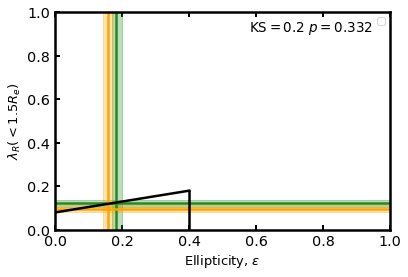

(45, 417)


In [15]:
filament_tab, control_tab, node_tab, ncw_tab,_ = return_tabs(etgs, min_mass=np.percentile(etgs.halo_mass_stel.values, 75), max_mass=np.percentile(etgs.halo_mass_stel.values, 100), mass_col='halo_mass_stel')
# plotting lambda_Re plot.
fig, ax = plt.subplots()
ax.axhline(np.median(filament_tab.lambda_re.values), color='forestgreen', label='')
ax.axhspan(np.median(filament_tab.lambda_re.values) - stats.sem(filament_tab.lambda_re.values),
           np.median(filament_tab.lambda_re.values) + stats.sem(filament_tab.lambda_re.values), 
           linestyle='solid', color='forestgreen', alpha=0.3, zorder=2)
ax.axvline(np.median(1 - filament_tab.nsa_elpetro_ba.values), color='forestgreen')
ax.axvspan(np.median(1 - filament_tab.nsa_elpetro_ba.values) - stats.sem(1 - filament_tab.nsa_elpetro_ba.values),
           np.median(1 - filament_tab.nsa_elpetro_ba.values) + stats.sem(filament_tab.lambda_re.values), 
           linestyle='solid', color='forestgreen', alpha=0.3, zorder=2)
#im = ax.scatter(1 - filament_Sb_Sds.nsa_elpetro_ba.values, filament_Sb_Sds.lambda_re.values, color='forestgreen')

ax.axhline(np.median(control_tab.lambda_re.values), color='orange')
ax.axvline(np.median(1 - control_tab.nsa_elpetro_ba.values),  color='orange')
ax.axhspan(np.median(control_tab.lambda_re.values) - stats.sem(control_tab.lambda_re.values),
           np.median(control_tab.lambda_re.values) + stats.sem(control_tab.lambda_re.values), 
           linestyle='solid', color='orange', alpha=0.3, zorder=2)
ax.axvspan(np.median(1 - control_tab.nsa_elpetro_ba.values) - stats.sem(1 - control_tab.nsa_elpetro_ba.values),
           np.median(1 - control_tab.nsa_elpetro_ba.values) + stats.sem(control_tab.lambda_re.values), 
           linestyle='solid', color='orange', alpha=0.3, zorder=2)

# ax.axhline(np.median(node_tab.lambda_re.values), color='steelblue')
# ax.axvline(np.median(1 - node_tab.nsa_elpetro_ba.values),  color='steelblue')
# ax.axhspan(np.median(node_tab.lambda_re.values) - stats.sem(node_tab.lambda_re.values),
#            np.median(node_tab.lambda_re.values) + stats.sem(node_tab.lambda_re.values), 
#            linestyle='solid', color='steelblue', alpha=0.3, zorder=2)
# ax.axvspan(np.median(1 - node_tab.nsa_elpetro_ba.values) - stats.sem(1 - node_tab.nsa_elpetro_ba.values),
#            np.median(1 - node_tab.nsa_elpetro_ba.values) + stats.sem(node_tab.lambda_re.values), 
#            linestyle='solid', color='steelblue', alpha=0.3, zorder=2)

ks, p = stats.ks_2samp(filament_tab.lambda_re.values, control_tab.lambda_re.values)
ax.annotate(r'$\mathrm{KS}=$'+str(round(ks, 3))+r' $p=$'+str(np.round(p, 3)), 
               xy=(0.58, 0.91), xycoords='axes fraction', fontsize=13.5 )

# adding on classically defined SR region 
elp_cond = np.linspace(0,0.4,10)
lam_cond = 0.08 + elp_cond/4
ax.plot(elp_cond,lam_cond,'k')
ax.plot([0.4,0.4],[0,0.18],'k')

ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel('Ellipticity, $\epsilon$', fontsize=13)
ax.set_ylabel(r'$\lambda_{R}(< 1.5R_{e})$', fontsize=13)
ax.legend()
ax.set_xlim([0,1])
ax.set_ylim([0,1])
plt.show()
print(filament_tab.shape)

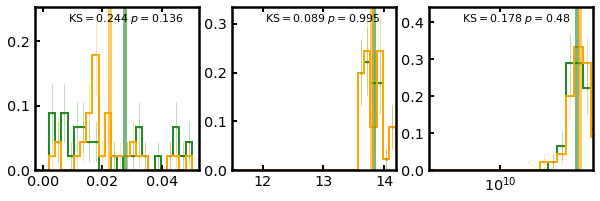

In [16]:
bins = np.linspace(0, 0.05, 25)
fig, ax = plt.subplots(1,3, figsize=(10,3))
knf.histerr(filament_tab.dtfe_gauss_3Mpc.values, ax[0], bins=bins, color='forestgreen', median=True)
knf.histerr(control_tab.dtfe_gauss_3Mpc.values, ax[0], bins=bins, color='orange', median=True)
ks, p = stats.ks_2samp(filament_tab.dtfe_gauss_3Mpc.values, control_tab.dtfe_gauss_3Mpc.values)
ax[0].annotate(r'$\mathrm{KS}=$'+str(round(ks, 3))+r' $p=$'+str(np.round(p, 3)), 
               xy=(0.2, 0.91), xycoords='axes fraction', fontsize=11)

bins = np.linspace(11.5, 14.5, 30)
knf.histerr(filament_tab.halo_mass_stel.values, ax[1], bins=bins, color='forestgreen', median=True)
knf.histerr(control_tab.halo_mass_stel.values, ax[1], bins=bins, color='orange', median=True)

ks, p = stats.ks_2samp(filament_tab.halo_mass_stel.values, control_tab.halo_mass_stel.values)
ax[1].annotate(r'$\mathrm{KS}=$'+str(round(ks, 3))+r' $p=$'+str(np.round(p, 3)), 
               xy=(0.2, 0.91), xycoords='axes fraction', fontsize=11 )
ax[1].set_xlim([11.5,14.2])

bins = np.logspace(8.5, 12, 30)
knf.histerr(filament_tab.nsa_elpetro_mass.values, ax[2], bins=bins, color='forestgreen', median=True)
knf.histerr(control_tab.nsa_elpetro_mass.values, ax[2], bins=bins, color='orange', median=True)

ks, p = stats.ks_2samp(filament_tab.nsa_elpetro_mass.values, control_tab.nsa_elpetro_mass.values)
ax[2].annotate(r'$\mathrm{KS}=$'+str(round(ks, 3))+r' $p=$'+str(np.round(p, 3)),
               xy=(0.2, 0.91), xycoords='axes fraction', fontsize=11)
ax[2].set_xscale('log')
ax[2].set_xlim([10**9, 10**11.3])
plt.show()


In [34]:
np.percentile(S0_Sas.halo_mass_stel.values, 33), np.percentile(S0_Sas.halo_mass_stel.values, 66)

(12.125864, 12.683784)

### Creating plotting function.
- 1) Plots all individual points for each sub-distribution.
- 2) Plots averages and errorbars for bins.

In [17]:
def plot_lambdaR_mhalo(tab, fil_color='chartreuse', con_color='lightslategrey', label=None):
    # Finding percentiles (splitting at 33, 66)
    upper = np.percentile(tab.halo_mass_stel.values, 66)
    lower = np.percentile(tab.halo_mass_stel.values, 33)
    
    # sub-selecting percentile tabs.
    upper_tab, upper_control_tab, _, _, _ = return_tabs(tab[(tab.halo_mass_stel.values > upper) & (tab.halo_mass_stel.values < 14.5)], min_mass=0, max_mass=1, mass_col='dtfe_gauss_3Mpc')
    middle_tab, middle_control_tab, _, _, _ = return_tabs(tab[(tab.halo_mass_stel.values <= upper) & (tab.halo_mass_stel.values >= lower)], min_mass=0, max_mass=1, mass_col='dtfe_gauss_3Mpc')
    lower_tab, lower_control_tab, _, _, _ = return_tabs(tab[tab.halo_mass_stel.values < lower], min_mass=0, max_mass=1, mass_col='dtfe_gauss_3Mpc')
    
    # setting up figure.
    fig, ax = plt.subplots(1, figsize=(10, 4))
    
    # plotting filament samples.
    ax.plot(lower_tab.halo_mass_stel.values, lower_tab.lambda_re.values, color=fil_color, marker='v', linestyle='None', alpha=0.3, markersize=2)
    ax.plot(middle_tab.halo_mass_stel.values, middle_tab.lambda_re.values, color=fil_color, marker='v', linestyle='None', alpha=0.3, markersize=2)
    ax.plot(upper_tab.halo_mass_stel.values, upper_tab.lambda_re.values, color=fil_color, marker='v', linestyle='None', alpha=0.3, markersize=2)

    # plotting control samples.
    ax.plot(lower_control_tab.halo_mass_stel.values, lower_control_tab.lambda_re.values, color=con_color, marker='^', linestyle='None', alpha=0.3, markersize=2)
    ax.plot(middle_control_tab.halo_mass_stel.values, middle_control_tab.lambda_re.values, color=con_color, marker='^', linestyle='None', alpha=0.3, markersize=2)
    ax.plot(upper_control_tab.halo_mass_stel.values, upper_control_tab.lambda_re.values, color=con_color, marker='^', linestyle='None', alpha=0.3, markersize=2)
    
    # overplotting the average values in each bin.
    ax.errorbar([np.median(lower_tab.halo_mass_stel.values), np.median(middle_tab.halo_mass_stel.values), np.median(upper_tab.halo_mass_stel.values)],
                [np.median(lower_tab.lambda_re.values), np.median(middle_tab.lambda_re.values), np.median(upper_tab.lambda_re.values)], 
                yerr=[stats.sem(lower_tab.lambda_re.values), stats.sem(middle_tab.lambda_re.values), stats.sem(upper_control_tab.lambda_re.values)], 
                 color=fil_color, marker='H', markersize=5, capsize=5)
    
    ax.errorbar([np.median(lower_control_tab.halo_mass_stel.values), np.median(middle_control_tab.halo_mass_stel.values), np.median(upper_control_tab.halo_mass_stel.values)],
                [np.median(lower_control_tab.lambda_re.values), np.median(middle_control_tab.lambda_re.values), np.median(upper_control_tab.lambda_re.values)], 
                yerr=[stats.sem(lower_control_tab.lambda_re.values), stats.sem(middle_control_tab.lambda_re.values), stats.sem(upper_control_tab.lambda_re.values)], 
                 color=con_color, marker='H', markersize=5, capsize=5)

    #ax.errorbar(np.median(middle_tab.halo_mass_stel.values), np.median(middle_tab.lambda_re.values), yerr=stats.sem(middle_tab.lambda_re.values), color=fil_color, marker='H', markersize=5, capsize=5)
    #ax.errorbar(np.median(upper_tab.halo_mass_stel.values), np.median(upper_tab.lambda_re.values), yerr=stats.sem(upper_tab.lambda_re.values), color=fil_color, marker='H', markersize=5, capsize=5)
    
    #ax.errorbar(np.median(lower_control_tab.halo_mass_stel.values), np.median(lower_control_tab.lambda_re.values), yerr=stats.sem(lower_control_tab.lambda_re.values), color=con_color, marker='H', markersize=5, capsize=5)
    #ax.errorbar(np.median(middle_control_tab.halo_mass_stel.values), np.median(middle_control_tab.lambda_re.values), yerr=stats.sem(middle_control_tab.lambda_re.values), color=con_color, marker='H', markersize=5, capsize=5)
    #ax.errorbar(np.median(upper_control_tab.halo_mass_stel.values), np.median(upper_control_tab.lambda_re.values), yerr=stats.sem(upper_control_tab.lambda_re.values), color=con_color, marker='H', markersize=5, capsize=5)
    
    # adding percentile vertical lines to denote boundaries.
    ax.axvline(upper, color='k', alpha=0.3, linestyle='dashed')
    ax.axvline(lower, color='k', alpha=0.3, linestyle='dashed')
    
    # adding KS-tests in each mini-panel.
    ks, p = stats.ks_2samp(lower_tab.lambda_re.values, lower_control_tab.lambda_re.values)
    ax.annotate(r'$\mathrm{KS}=$'+str(round(ks, 3))+'\n $p=$'+str(np.round(p, 3))+'\n n='+str(lower_tab.shape[0]), 
                xy=(np.median(lower_tab.halo_mass_stel.values)-0.1, 0.8), xycoords='data', fontsize=11)
    
    ks, p = stats.ks_2samp(middle_tab.lambda_re.values, middle_control_tab.lambda_re.values)
    ax.annotate(r'$\mathrm{KS}=$'+str(round(ks, 3))+'\n $p=$'+str(np.round(p, 3))+'\n n='+str(middle_tab.shape[0]), 
                xy=(np.median(middle_tab.halo_mass_stel.values)-0.1, 0.8), xycoords='data', fontsize=11)
    
    ks, p = stats.ks_2samp(upper_tab.lambda_re.values, upper_control_tab.lambda_re.values)
    ax.annotate(r'$\mathrm{KS}=$'+str(round(ks, 3))+'\n $p=$'+str(np.round(p, 3))+'\n n='+str(upper_tab.shape[0]),
                xy=(np.median(upper_tab.halo_mass_stel.values)-0.1, 0.8), xycoords='data', fontsize=11)
    
    # Adding label to top right corner.
    ax.annotate(label, xy=(13.65, 0.9), xycoords='data', fontsize=14)
    
    # formatting final plot.
    #ax.set_xscale('log')
    ax.set_ylabel(r'$\mathrm{\lambda_{R}(< 1.5R_{e})}$', fontsize=13)
    ax.set_xlabel(r'$\mathrm{M_{halo}}$', fontsize=13)
    ax.set_xlim((np.min(tab.halo_mass_stel.values), 14))
    ax.set_ylim((0,1))
    return ax

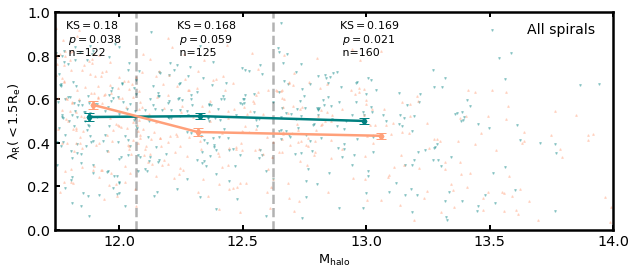

In [18]:
plot_lambdaR_mhalo(all_spirals, fil_color='teal', con_color='lightsalmon', label='All spirals')
plt.savefig('test_allspirals_lambdaR_Mhalo.pdf', format='pdf', bbox_inches='tight')

In [19]:
def plot_mstel(tab, fil_color='chartreuse', con_color='lightslategrey', label=None):
    # Finding percentiles (splitting at 33, 66)
    upper = np.percentile(tab.halo_mass_stel.values, 66)
    lower = np.percentile(tab.halo_mass_stel.values, 33)
    
    # sub-selecting percentile tabs.
    upper_tab, upper_control_tab, _, _, _ = return_tabs(tab[(tab.halo_mass_stel.values > upper) & (tab.halo_mass_stel.values < 14.5)], min_mass=0, max_mass=1, mass_col='dtfe_gauss_3Mpc')
    middle_tab, middle_control_tab, _, _, _ = return_tabs(tab[(tab.halo_mass_stel.values <= upper) & (tab.halo_mass_stel.values >= lower)], min_mass=0, max_mass=1, mass_col='dtfe_gauss_3Mpc')
    lower_tab, lower_control_tab, _, _, _ = return_tabs(tab[tab.halo_mass_stel.values < lower], min_mass=0, max_mass=1, mass_col='dtfe_gauss_3Mpc')
    
    # setting up figure.
    fig, ax = plt.subplots(1,3, figsize=(10, 2.5), sharex='all', sharey='all')
    bins = np.logspace(8.5, 12, 35)
    knf.histerr(lower_tab.nsa_elpetro_mass.values, ax[0], bins=bins, color=fil_color, median=True)
    knf.histerr(lower_control_tab.nsa_elpetro_mass.values, ax[0], bins=bins, color=con_color, median=True)
    
    knf.histerr(middle_tab.nsa_elpetro_mass.values, ax[1], bins=bins, color=fil_color, median=True)
    knf.histerr(middle_control_tab.nsa_elpetro_mass.values, ax[1], bins=bins, color=con_color, median=True)
    
    knf.histerr(upper_tab.nsa_elpetro_mass.values, ax[2], bins=bins, color=fil_color, median=True)
    knf.histerr(upper_control_tab.nsa_elpetro_mass.values, ax[2], bins=bins, color=con_color, median=True)
    
    # adding KS-tests in each mini-panel.
    ks, p = stats.ks_2samp(lower_tab.nsa_elpetro_mass.values, lower_control_tab.nsa_elpetro_mass.values)
    ax[0].annotate('$\mathrm{KS}=$'+str(round(ks, 3))+'\n $p=$'+str(np.round(p, 3))+'\n n='+str(lower_tab.shape[0]), 
                   xy=(10**9.05, 0.32), xycoords='data', fontsize=11)
    
    ks, p = stats.ks_2samp(middle_tab.nsa_elpetro_mass.values, middle_control_tab.nsa_elpetro_mass.values)
    ax[1].annotate('$\mathrm{KS}=$'+str(round(ks, 3))+'\n $p=$'+str(np.round(p, 3))+'\n n='+str(middle_tab.shape[0]), 
                   xy=(10**9.05, 0.32), xycoords='data', fontsize=11)
    
    ks, p = stats.ks_2samp(upper_tab.nsa_elpetro_mass.values, upper_control_tab.nsa_elpetro_mass.values)
    ax[2].annotate('$\mathrm{KS}=$'+str(round(ks, 3))+'\n $p=$'+str(np.round(p, 3))+'\n n='+str(upper_tab.shape[0]),
                   xy=(10**9.05, 0.32), xycoords='data', fontsize=11) 
    
    ax[0].set_ylabel('PDF', fontsize=13)    
    ax[0].set_xscale('log')
    ax[0].set_xlim([10**9, 10**11.5])
    
    ax[0].set_xlabel('$\mathrm{M_{stel}}$', fontsize=13)
    ax[1].set_xlabel('$\mathrm{M_{stel}}$', fontsize=13)
    ax[2].set_xlabel('$\mathrm{M_{stel}}$', fontsize=13)
    fig.subplots_adjust(wspace=0, hspace=0.1)
    return

def plot_mhalo(tab, fil_color='chartreuse', con_color='lightslategrey', label=None):
    # Finding percentiles (splitting at 33, 66)
    upper = np.percentile(tab.halo_mass_stel.values, 66)
    lower = np.percentile(tab.halo_mass_stel.values, 33)
    
    # sub-selecting percentile tabs.
    upper_tab, upper_control_tab, _, _, _ = return_tabs(tab[(tab.halo_mass_stel.values > upper) & (tab.halo_mass_stel.values < 14.5)], min_mass=0, max_mass=1, mass_col='dtfe_gauss_3Mpc')
    middle_tab, middle_control_tab, _, _, _ = return_tabs(tab[(tab.halo_mass_stel.values <= upper) & (tab.halo_mass_stel.values >= lower)], min_mass=0, max_mass=1, mass_col='dtfe_gauss_3Mpc')
    lower_tab, lower_control_tab, _, _, _ = return_tabs(tab[tab.halo_mass_stel.values < lower], min_mass=0, max_mass=1, mass_col='dtfe_gauss_3Mpc')
    
    # setting up figure.
    fig, ax = plt.subplots(1,3, figsize=(10, 2.5), sharex='all', sharey='all')
    bins = np.linspace(11.5, 14.5, 35)
    knf.histerr(lower_tab.halo_mass_stel.values, ax[0], bins=bins, color=fil_color, median=True)
    knf.histerr(lower_control_tab.halo_mass_stel.values, ax[0], bins=bins, color=con_color, median=True)
    
    knf.histerr(middle_tab.halo_mass_stel.values, ax[1], bins=bins, color=fil_color, median=True)
    knf.histerr(middle_control_tab.halo_mass_stel.values, ax[1], bins=bins, color=con_color, median=True)
    
    knf.histerr(upper_tab.halo_mass_stel.values, ax[2], bins=bins, color=fil_color, median=True)
    knf.histerr(upper_control_tab.halo_mass_stel.values, ax[2], bins=bins, color=con_color, median=True)
    
    # adding KS-tests in each mini-panel.
    ks, p = stats.ks_2samp(lower_tab.halo_mass_stel.values, lower_control_tab.halo_mass_stel.values)
    ax[0].annotate('$\mathrm{KS}=$'+str(round(ks, 3))+'\n $p=$'+str(np.round(p, 3))+'\n n='+str(lower_tab.shape[0]), 
                   xy=(11.6, 0.23), xycoords='data', fontsize=11)
    
    ks, p = stats.ks_2samp(middle_tab.halo_mass_stel.values, middle_control_tab.halo_mass_stel.values)
    ax[1].annotate('$\mathrm{KS}=$'+str(round(ks, 3))+'\n $p=$'+str(np.round(p, 3))+'\n n='+str(middle_tab.shape[0]), 
                   xy=(11.6, 0.23), xycoords='data', fontsize=11)
    
    ks, p = stats.ks_2samp(upper_tab.halo_mass_stel.values, upper_control_tab.halo_mass_stel.values)
    ax[2].annotate('$\mathrm{KS}=$'+str(round(ks, 3))+'\n $p=$'+str(np.round(p, 3))+'\n n='+str(upper_tab.shape[0]),
                   xy=(11.6, 0.23), xycoords='data', fontsize=11) 
    
    ax[0].set_ylabel('PDF', fontsize=13)    
    ax[0].set_xlim([11.5, 14.5])
    
    ax[0].set_xlabel('$\mathrm{M_{halo}}$', fontsize=13)
    ax[1].set_xlabel('$\mathrm{M_{halo}}$', fontsize=13)
    ax[2].set_xlabel('$\mathrm{M_{halo}}$', fontsize=13)
    fig.subplots_adjust(wspace=0, hspace=0.1)
    return

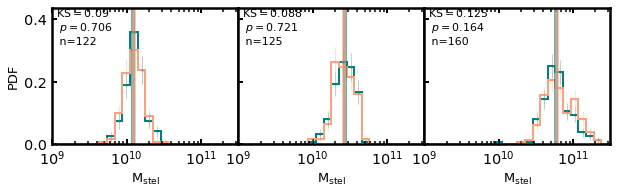

In [20]:
plot_mstel(all_spirals, fil_color='teal', con_color='lightsalmon')
plt.savefig('test_allspirals_Mstel.pdf', format='pdf', bbox_inches='tight')

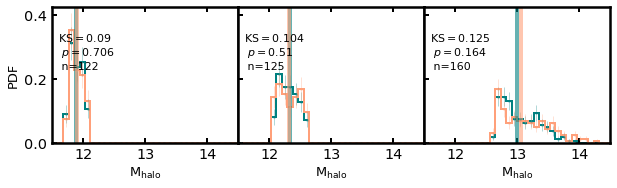

In [21]:
plot_mhalo(all_spirals, fil_color='teal', con_color='lightsalmon')
plt.savefig('test_allspirals_Mhalo.pdf', format='pdf', bbox_inches='tight')